### This notebook takes in features from the data to train a model that can accurately rank customers in different tier buckets based on their lifetime value with the business

In [1]:
import pandas as pd
import numpy as np 

df = pd.read_parquet("../data/processed/model_features.parquet")
df.sample(5)

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
24886,2021-12-15 00:55:00,16.961496,12,30,3,3,358.151763,457.612,400.883
15860,2021-11-15 02:27:00,46.897623,4,4,2,3,299.079232,62.840,39.723
22481,2021-12-09 07:53:00,22.671319,2,4,1,0,256.705381,53.793,0.000
11042,2021-10-11 19:40:00,81.180307,2,5,1,2,224.180087,54.725,0.000
6256,2021-08-07 04:44:00,146.802422,1,3,1,0,146.802422,158.667,0.000


__Let's visualize customer tenure distribution since we just added it as a model feature__

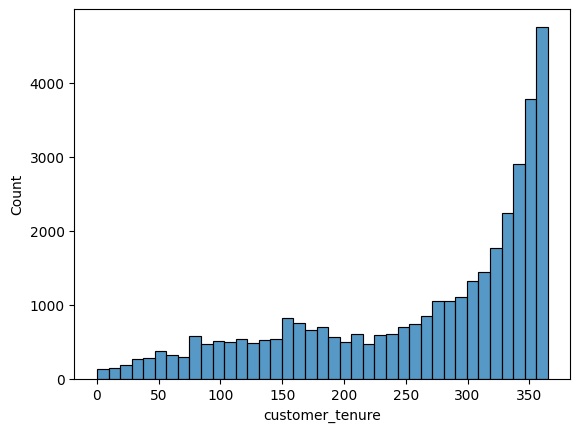

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df["customer_tenure"])
plt.show()

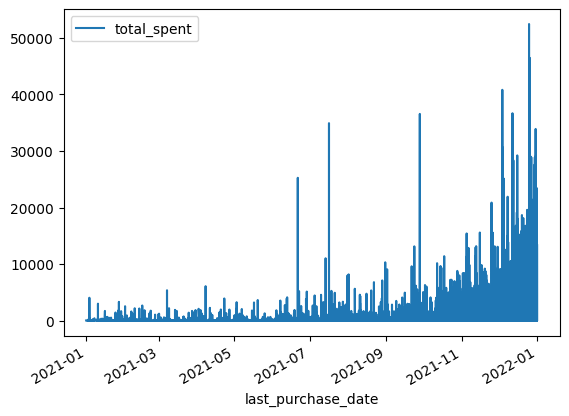

In [3]:
df.plot(x="last_purchase_date", y="total_spent")
plt.show()

In [4]:
log_features = ["transaction_count", "quantity", 
                "total_spent", "customer_tenure", "purchase_recency"]     
# these features a really right-skewed (from EDA notebook) so we log it to normalize its distribution

scale_features = ["payment_method_count", "promo_usage_count"]

# future_spend (the target) is not included

__We'll be setting up transformers inside a pipeline instead of doing it openly (helps avoid possible data leakage)__

In [5]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Applies np.log1p() to each feature to deal with outliers, then performs standard scaler on the logged values to keep variation between 0 and 1 still.
log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p)),     # performs log only on the features that require it
    ("scaler", StandardScaler())
])

scale_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())    # Only scales particular features, ones that don't need logging 
])


In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("log_features", log_transformer, log_features),
        ("scale_features", scale_transformer, scale_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('log_features',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['transaction_count', 'quantity',
                                  'total_spent', 'customer_tenure',
                                  'purchase_recency']),
                                ('scale_features',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['payment_method_count',
                                  'promo_usage_count'])])

### Seperating features from target variable

In [7]:
X = df.drop(columns=["future_spend", "last_purchase_date"])
y = df["future_spend"]

In [8]:
X.sample(5)

,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent
25474,15.648106,8,13,2,7,337.982284,235.673
24137,18.602930,13,21,1,13,354.833347,954.293
418,336.094057,1,1,1,0,336.094057,12.610
25822,14.920874,14,25,1,9,352.957622,622.817
15554,48.173761,2,2,1,1,309.455104,41.515


In [9]:
y.sample(5)

4269       0.000
22807    201.932
20353     82.624
28887    262.256
13234     18.777
Name: future_spend, dtype: float64

<hr/>

#### <h3 style = "text-align:center;"> Splitting the data (Time Series Split) </h3>

TimeSeriesSplit is used because it maintains the date order and gives multiple train-test folds. <br/> We'll be using the walk-forward cross-validation technique to evaluate on different train-test folds



In [10]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

xgb = XGBRegressor(
    random_state=42,
    n_jobs=4, 
    objective='reg:tweedie',  # good for skewed data and handles many 0s being present
    tweedie_variance_power=1.9
    )

# pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb)])
time_series_split = TimeSeriesSplit(n_splits=6)




<hr/>


#### <h3 style = "text-align:center;"> Evaluating Model Performance </h3>

You can say there we will evaluate the model's performance in two ways:
1. How far its predictions are from the actual value of a customer's future spend
2. How well the model is able to group customers into tiers (High, Mid, low) based on value provided to the business


In [11]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# We'll collect metrics for each fold and average it to get the overall performance
mae_scores = []
rmse_scores = []
fold_stats = []

for fold, (train_index, valid_index) in enumerate(time_series_split.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), # our preprocessor pipeline (log and scaling)
        ("model", xgb)])    # data is now fitten into our xgboost model

    pipeline.fit(X_train, y_train)  # pipeline fit only on training data

    # Runs prediction on the validation set
    preds = pipeline.predict(X_valid)

    mae  = mean_absolute_error(y_valid, preds)
    rmse = root_mean_squared_error(y_valid, preds)

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    # Collect descriptive stats for validation set
    valid_stats = {
        'fold': fold,
        'count': y_valid.count(),
        'mean': y_valid.mean(),
        'median': y_valid.median(),
        'std': y_valid.std(),
        'min': y_valid.min(),
        'max': y_valid.max(),
        'q25': y_valid.quantile(0.25),
        'q75': y_valid.quantile(0.75),
        'mae': mae,
        'rmse': rmse
    }
    fold_stats.append(valid_stats)

    print("=======================================")
    print(f"Fold {fold}")
    print(f"Train period: {X_train.index.min()} → {X_train.index.max()}")
    print(f"Valid period: {X_valid.index.min()} → {X_valid.index.max()}\n")
    print("Validation Set Statistics:")
    print(f"  Count: {y_valid.count()}")
    print(f"  Mean: {y_valid.mean():.2f}")
    print(f"  Median: {y_valid.median():.2f}")
    print(f"  Std Dev: {y_valid.std():.2f}")
    print(f"  Min: {y_valid.min():.2f}")
    print(f"  Max: {y_valid.max():.2f}")
    print(f"  Q1 (25%): {y_valid.quantile(0.25):.2f}")
    print(f"  Q3 (75%): {y_valid.quantile(0.75):.2f}\n")
    print(f"MAE for fold: {mae:.2f}")
    print(f"RMSE for fold: {rmse:.2f}")


print("\n" + "="*40)
print("Average performance")
print("="*40)
print(f"Average MAE across all folds : {np.mean(mae_scores):.2f}")
print(f"Average RMSE across all folds: {np.mean(rmse_scores):.2f}")


stats_df = pd.DataFrame(fold_stats)     # showing results summary in a dataframe
print("\nDetailed Stats by Fold:")
print(stats_df.to_string())





Fold 0
Train period: 0 → 5155
Valid period: 5156 → 10310

Validation Set Statistics:
  Count: 5155
  Mean: 23.26
  Median: 9.12
  Std Dev: 48.62
  Min: 0.00
  Max: 774.01
  Q1 (25%): 0.00
  Q3 (75%): 25.06

MAE for fold: 19.98
RMSE for fold: 50.32
Fold 1
Train period: 0 → 10310
Valid period: 10311 → 15465

Validation Set Statistics:
  Count: 5155
  Mean: 49.20
  Median: 26.19
  Std Dev: 72.22
  Min: 0.00
  Max: 939.76
  Q1 (25%): 0.00
  Q3 (75%): 61.99

MAE for fold: 43.11
RMSE for fold: 76.10
Fold 2
Train period: 0 → 15465
Valid period: 15466 → 20620

Validation Set Statistics:
  Count: 5155
  Mean: 84.40
  Median: 52.64
  Std Dev: 102.14
  Min: 0.00
  Max: 1308.59
  Q1 (25%): 14.39
  Q3 (75%): 115.63

MAE for fold: 52.14
RMSE for fold: 87.74
Fold 3
Train period: 0 → 20620
Valid period: 20621 → 25775

Validation Set Statistics:
  Count: 5155
  Mean: 150.73
  Median: 108.10
  Std Dev: 153.04
  Min: 0.00
  Max: 1414.49
  Q1 (25%): 38.41
  Q3 (75%): 214.55

MAE for fold: 74.10
RMSE for f

You can check out future spend over time but visualized, it shows the trend the model is working with and its MAE over time:

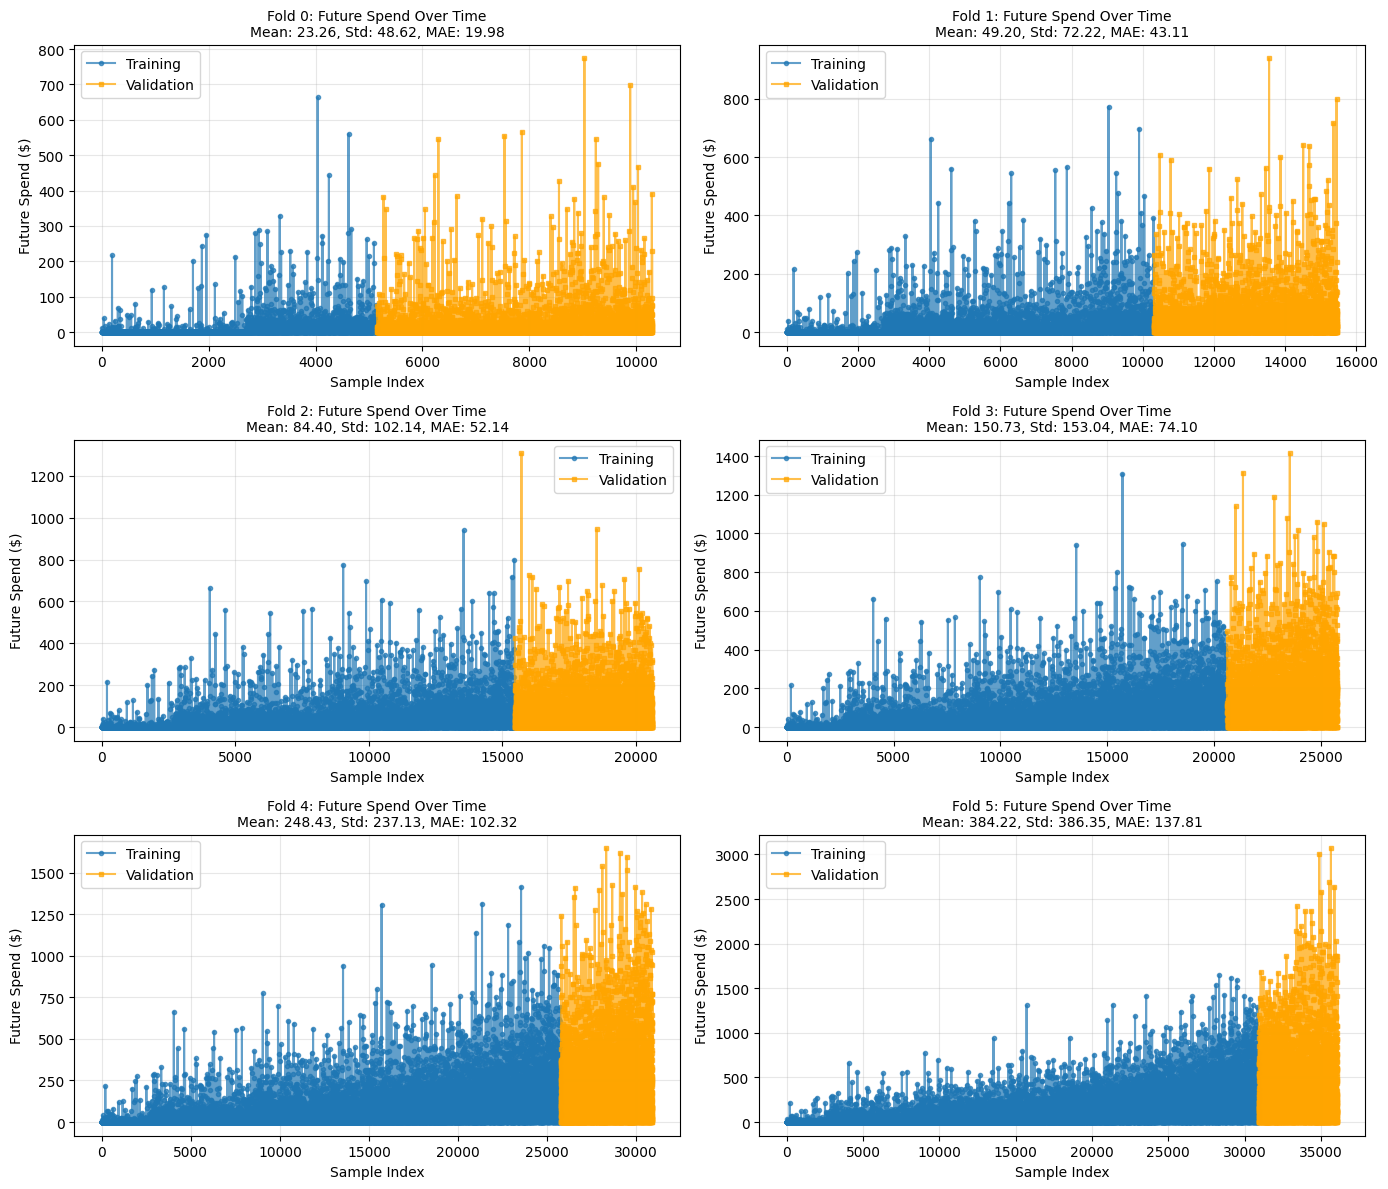

In [12]:

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for fold, (train_index, valid_index) in enumerate(time_series_split.split(X)):
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    ax = axes[fold]
    
    # Plot training and validation data
    ax.plot(y_train.index, y_train.values, label='Training', alpha=0.7, marker='o', markersize=3)
    ax.plot(y_valid.index, y_valid.values, label='Validation', alpha=0.7, marker='s', markersize=3, color='orange')
    
    ax.set_title(f'Fold {fold}: Future Spend Over Time\nMean: {y_valid.mean():.2f}, Std: {y_valid.std():.2f}, MAE: {fold_stats[fold]["mae"]:.2f}', fontsize=10)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Future Spend ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

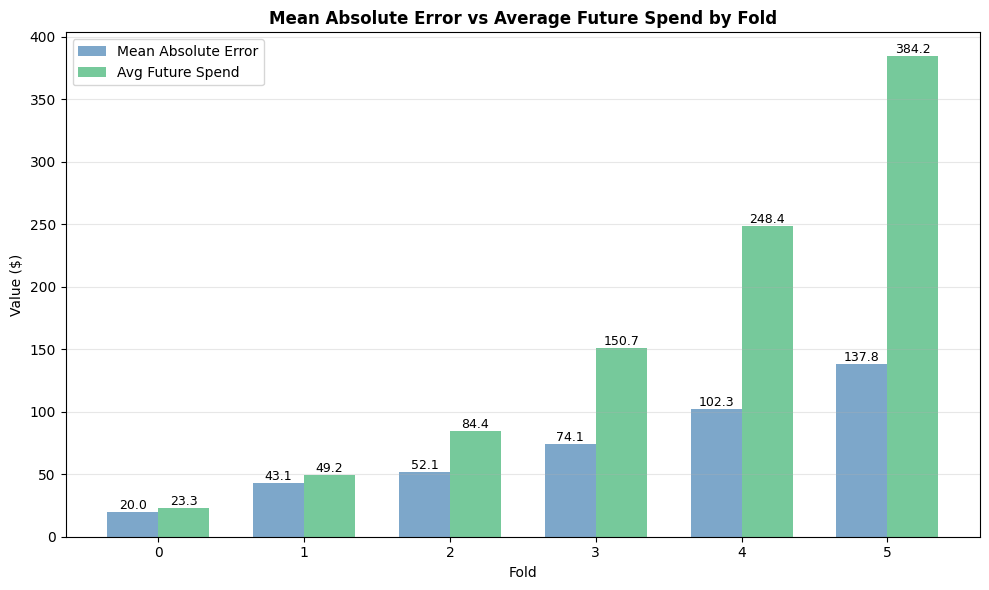

In [13]:
# Comparative analysis: Average Future Spend vs MAE per fold
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(stats_df['fold']))
width = 0.35

bars1 = ax.bar(x - width/2, stats_df['mae'], width, label='Mean Absolute Error', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, stats_df['mean'], width, label='Avg Future Spend', color='mediumseagreen', alpha=0.7)

# Add data labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

ax.set_title('Mean Absolute Error vs Average Future Spend by Fold', fontsize=12, fontweight='bold')
ax.set_xlabel('Fold')
ax.set_ylabel('Value ($)')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['fold'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


__From the image above:__
+ Fold 0: MAE (19.9) / Mean (23.2) = 86% Error Ratio
+ Fold 2: MAE (52.1) / Mean (84.4) = 61% Error Ratio
+ Fold 5: MAE (137.8) / Mean (384.2) = 35% Error Ratio

__The model is actually becoming relatively more accurate in the later folds. Even though the MAE value is higher in Fold 5, it is a smaller fraction of the total spend compared to Fold 0__

__for example, having an MAE of 1000 might seem high but it's really good if all transactions happening are in millions__

<hr/>

In [14]:
df[["total_spent", "future_spend"]].describe()

,total_spent,future_spend
count,36086.000000,36086.000000
mean,708.793996,135.517851
std,1759.728243,227.197064
min,1.635000,0.000000
25%,33.018000,0.000000
50%,130.647500,42.775000
75%,576.420000,167.486250
max,52428.261000,3069.269000


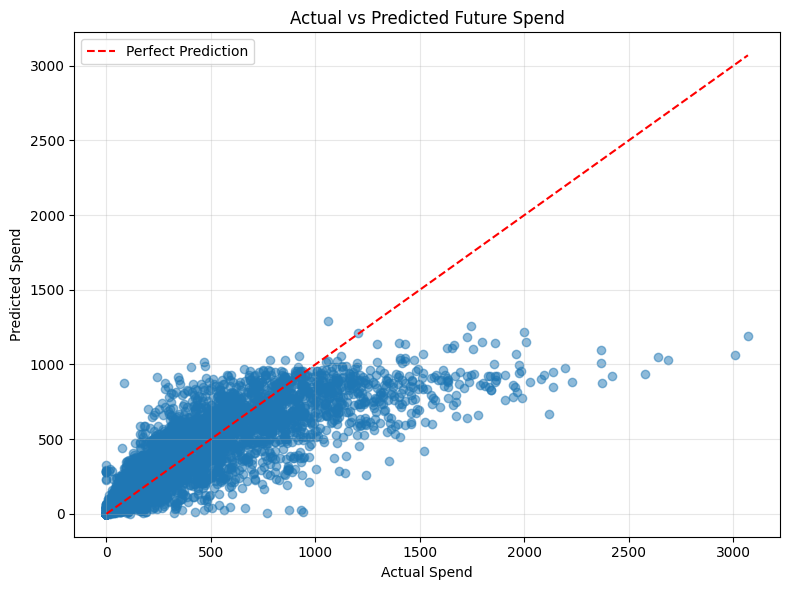

In [15]:
df_results = pd.DataFrame({'actual_spend': y_valid, 'predicted_spend': preds})

plt.figure(figsize=(8, 6))
plt.scatter(df_results['actual_spend'], df_results['predicted_spend'], alpha=0.5)
plt.plot([df_results['actual_spend'].min(), df_results['actual_spend'].max()],
         [df_results['actual_spend'].min(), df_results['actual_spend'].max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Spend')
plt.ylabel('Predicted Spend')
plt.title('Actual vs Predicted Future Spend')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

__The model's predictions are less accurate for higher transaction amounts.__ <br/>
__Our main ain is for the model to be able to properly group customers into high, mid and low value.__<br/>
__The accuracy of its grouping will depend on how accurate its actual value predictions are. So there is some room for variance as long as it is properly grouped__

In [16]:
high_cutoff = df_results['actual_spend'].quantile(0.80)     # The top 20% of customers spends 651.2328 or more
mid_cutoff = df_results['actual_spend'].quantile(0.50)      # The middle 30% after, spends 261.763 or more

print(f"High Value Threshold: ${high_cutoff:.2f}")
print(f"Mid Value Threshold: ${mid_cutoff:.2f}")


def assign_tier(value, high, mid):
    if value >= high:
        return 'High'
    elif value >= mid:
        return 'Mid'
    else:
        return 'Low'


df_results['actual_tier'] = df_results['actual_spend'].apply(lambda x: assign_tier(x, high_cutoff, mid_cutoff))
df_results['predicted_tier'] = df_results['predicted_spend'].apply(lambda x: assign_tier(x, high_cutoff, mid_cutoff))

df_results.sample(5)

High Value Threshold: $651.23
Mid Value Threshold: $261.76


,actual_spend,predicted_spend,actual_tier,predicted_tier
34441,188.795,217.059036,Low,Low
35522,682.317,914.053162,High,High
32227,8.223,38.604294,Low,Low
32946,215.882,648.523987,Low,Mid
33443,566.052,570.815979,Mid,Mid


In [17]:

correct_predictions = (df_results['actual_tier'] == df_results['predicted_tier']).sum()
total_predictions = len(df_results)
accuracy = (correct_predictions / total_predictions) * 100

print(f"Total Correct Tier Assignments: {correct_predictions} / {total_predictions}")
print(f"Overall Tier Accuracy: {accuracy:.2f}%")

Total Correct Tier Assignments: 3862 / 5155
Overall Tier Accuracy: 74.92%
